In [1]:
%matplotlib inline
import numpy as np
import pylab as plt
import seaborn as snb

from scipy.stats import wishart
from scipy.stats import multivariate_normal as mvn

from PIL import Image

from exercise9 import VariationalGMM
from exercise9 import plot_std_dev_contour
from exercise9 import PCA_dim_reduction

# plotting and style stuff
snb.set_style('darkgrid')
snb.set(font_scale=1.5)
colors = snb.color_palette()


# 02477 Bayesian Machine Learning - Exercise 9

In this exercise we will study Bayesian inference for the Gaussian Mixture model using variational inference. You will also become familiar with the Dirichlet and Wishart distributions. 

The exercise is divided into four parts:

- Part 1: The Bayesian Gaussian Mixture Model


- Part 2: Variational inference for the Gaussian mixture model


- Part 3: Analyzing a toy data set


- Part 4: Clustering images using the variational GMM

### Part 1: Bayesian Gaussian Mixture Model

**The Gaussian mixture model** is very common in machine learning and statistics with a multitude of applications in clustering, density estimation, and outlier detection. It is also often used a building blocks in more complicated models.

The Gaussian mixture model (GMM) for $D$-dimensional data is a weighted mixture of $K$ Gaussians:

$$\begin{align*}
p(x_n|\pi, m, \Lambda) = \sum_{k=1}^K \pi_k N(x_n|m_k, \Lambda_k^{-1}), \tag{1}
\end{align*}
$$

where $m_k \in \mathbb{D}^D$ and $\Lambda_k \in \mathbb{R}^{D \times D}$ are the mean vector and precision matrix for the $k$'th component. The parameters $\pi_k \in [0, 1]$ for $k = 1, .., K$ are the **mixing weights** and satisfy $\sum_{k=1}^K \pi_k = 1$. Intuitively, $\pi_k$ represents the fraction of samples belonging to the $k$'th component.

**The GMM as a latent variable model**

The GMM can also be formulated as a latent variable model with latent variables $z_n$ such that

$$\begin{align*}
p(x_n|z_n, m, \Lambda) = \prod_{k=1}^K N(x_n|m_k, \Lambda_k^{-1})^{z_{nk}} \tag{2}
\end{align*}
$$

where $z_n$ is a $K$-dimensional one-hot encoded binary vector indicating the component index for the $n$'th observation. The distribution of the latent variables is given by

$$\begin{align*}
p(z_n|\pi) = \text{Categorial}(z_n|\pi) = \prod_{k=1}^K \pi_k^{z_{nk}} \tag{3},
\end{align*}
$$

where $\pi_k$ is the proportion of sample from the $k$'th component, i.e. $p(z_n=k) = \pi_k$. The variable $z_n$ is called a **latent variable** because we can't observe it, we can only observe $x_n$. 

We can easily derive the marginalized formulation in eq. (1) from the latent variable formulation in eq. (2)-(3) by applying to sum rule to marginalize over the latent variable $z_n$, i.e. $p(x_n) = \sum_{k} p(x_n|z_n=k)p(z_n=k)$.



**Maximum likelihood**

The classic way to estimate the model parameters for GMMs ($m_k, \Lambda_k, \pi_k$ for $k = 1, .., K$) is through maximum likelihood estimation using the Expectation-Maximimization (EM) algorithm (not part of the curriculum of this course). However, the maximum likelihood solution is not well-posed and can suffer from singularities when a component "collapses" on a single data point. This causes the variance component for the collapsing component to go to zero and eventually the algorithm will crash.

**Imposing priors**

We can avoid these issues by using Bayesian inference to estimate the parameters. As usual, we impose prior distributions on the parameters: $m_k$, $\Lambda_k$, and $\pi_k$:

$$\begin{align*}
\pi &\sim \text{Dirichlet}(\alpha_0)\\
%
\Lambda_k &\sim \text{Wishart}(W_0, \nu_0)\\
%
\mu_k|\Lambda_k &\sim \text{Normal}(m_0, \left(\beta_0\Lambda_k\right)^{-1})\\
%
z_n|\pi &\sim \text{Categorical}(\pi)\\
%
x_n|\mu, \Lambda, z_n &\sim \text{Normal}(\mu_{z_n}, \Lambda_{z_n}^{-1}),
\end{align*}
$$

where we consider all parameters with subscript '0' as hyperparameters. 



**Generative story**

We can interret and visualize the assumptions of the model by considering the generative story of the model. Assume the number of observations $N$ and the number of components $K$ are fixed. By using Bayesian GMM to model a data set, we assume that the data set has been generated in the following way:

1. Nature samples the mixing weights $\pi\sim \text{Dirichlet}(\alpha_0)$


2. Nature samples a precision matrix $\Lambda_k\sim \text{Wishart}(W_0, \nu_0)$ for each component $k = 1, ..., K$


3. Nature then samples a mean $m_k|\Lambda_k\sim \text{Normal}(m_0, \left(\beta_0\Lambda_k\right)^{-1})$ for each component $k=1, ..., K$ conditioned on $\Lambda_k$


4. For each data point, nature samples a component index $z_n|\pi \sim \text{Categorical}(\pi)$


5. For each data point, nature samples an observation from the relevant cluster distribution $x_n|\mu, \Lambda, z_n \sim \text{Normal}(\mu_{z_n}, \Lambda_{z_n}^{-1})$


We can use **ancestral sampling** to generate synthetic data sets from this model:


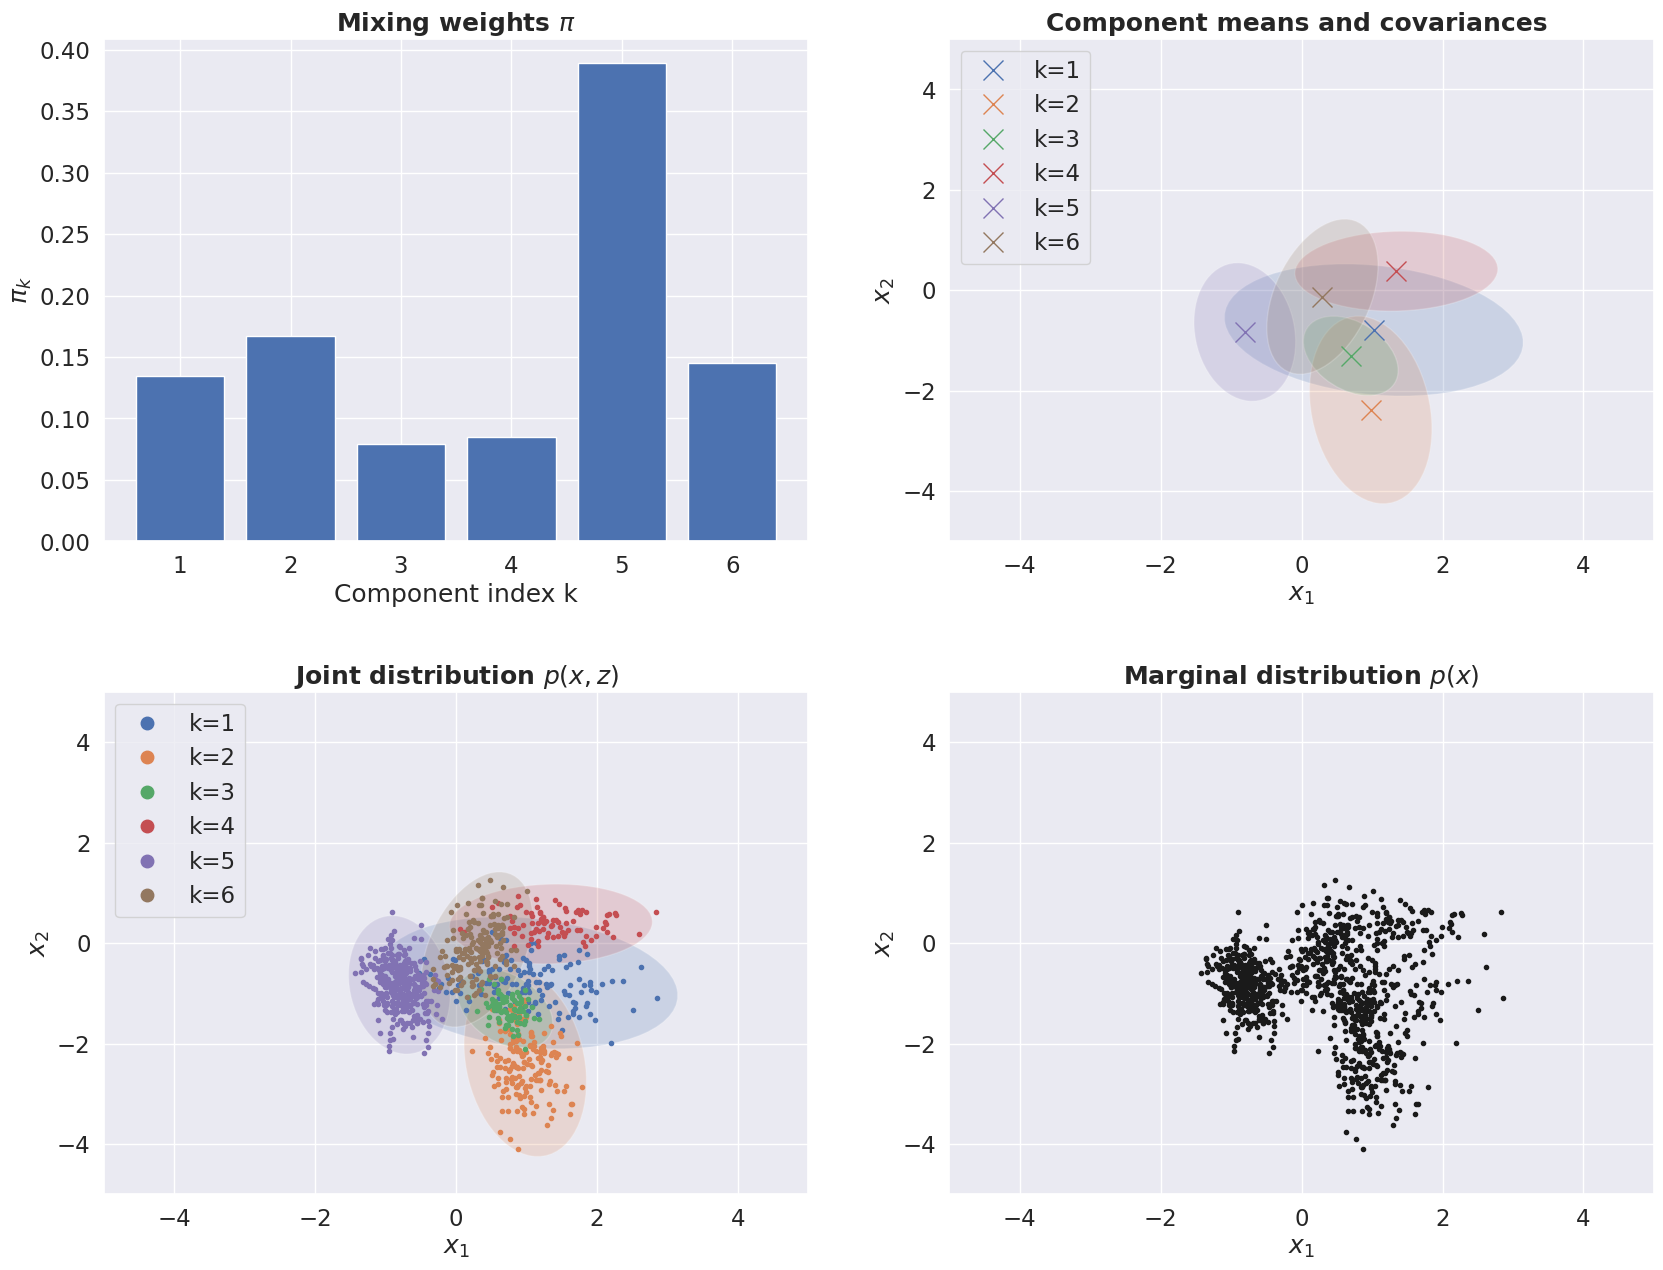

In [9]:
np.random.seed(0)

# number of components K,  dimension D, and number of observations N
K = 6
D = 2
N = 1000

# hyperparameter for the Dirichlet distribution
alpha0 = 0.5*np.ones(K)

# hyperparameters for the components
m0 = np.zeros(D)
W0 = np.identity(D)
nu0 = 10
beta0 = 0.1

# Step 1: sample mixing weights
pi = np.random.dirichlet(alpha0)

# Step 2: sample prior precision matrix for each component
Lk = wishart.rvs(nu0, W0, size=K)

# Step 3: sample prior mean vector for each component
mk = np.zeros((K, D))
Sk = np.zeros((K, D, D))
for k in range(K):
    Sk[k, :, :] = np.linalg.inv(Lk[k])
    mk[k, :] = np.random.multivariate_normal(m0, Sk[k]/beta0)
    
# Step 4: sample latent variable for each observation
z = np.random.choice(range(K), size=N, p=pi)

# Step 5: sample observations for all n
X = np.zeros((N, D))
for n in range(N):
    X[n] = np.random.multivariate_normal(mk[z[n]], Sk[z[n]])

# Visualize
fig, axes = plt.subplots(2, 2, figsize=(20, 15))

# plot mixing weights
axes[0,0].bar(np.arange(1,K+1), pi)
axes[0,0].set(xlabel='Component index k', ylabel = '$\pi_k$', xticks=np.arange(1, K+1))
axes[0,0].set_title('Mixing weights $\pi$', fontweight='bold')

# plot component mean and covariances
for k in range(K):
    axes[0,1].plot(mk[k, 0], mk[k, 1], 'x', color=colors[k], markersize=15, label='k=%d' % (k+1)) 
    plot_std_dev_contour(axes[0, 1], mk[k], Sk[k], facecolor=colors[k], alpha=0.2)
    plot_std_dev_contour(axes[1, 0], mk[k], Sk[k], facecolor=colors[k], alpha=0.2)
    axes[1,0].plot(X[z==k, 0], X[z==k, 1], '.', color=colors[k], label='k=%d' % (k+1))

axes[0,1].set_title('Component means and covariances ', fontweight='bold')
axes[0,1].legend()
axes[1,0].set_title('Joint distribution $p(x, z)$', fontweight='bold');
axes[1,0].legend(markerscale=3)

# plot observations
axes[1,1].plot(X[:, 0], X[:, 1], '.', color='k')
axes[1,1].set_title('Marginal distribution $p(x)$', fontweight='bold');
    
# add labels etc
for a in [1, 2, 3]:
    axes.flat[a].set(xlim = (-5, 5), ylim=(-5, 5), xlabel='$x_1$', ylabel='$x_2$')

fig.subplots_adjust(hspace=0.3)

**Questions**

1.1) Why is the Dirichlet distribution sometimes called a "distribution over distributions"?
* Each value in the sample is between 0 and 1 and all values sum to 1
* So from the Dirichlet distribution we sample the weights of mixing propotions

*Hint: What is the sample space of a Dirichlet distribution?*


1.2) How does the hyperparameter $\alpha_0$ affect the generated samples? Explore the generated datasets for different values of $\alpha_0$, e.g. $\alpha_0 = 0.2 \cdot \mathbf{1}$, $\alpha_0 = 1 \cdot \mathbf{1}$, and $\alpha_0 = 10 \cdot \mathbf{1}$, where $\mathbf{1}$ is a $K$-dimensional vector of ones. Inspect the results for a few different random seeds.
* For $\alpha_0 < 1$ the model will be pushed towards not mixing distributions and instead use specific distributions and drive the weight of other distributions in the mixture towards 0. In this way the model will be regularized in a way and give a sparse solution
* For $\alpha = 1$ we have a flat prior on the mixing proportions, so it's like saying that we don't really know anything about how the distributions should be mixed or not, so we allow each option equally much and the Dirichlet becomes a constant.
* For high $\alpha$ values we force the model to use all mixing proportions and thereby keep all clusters to model the data

1.3) What is the sample space of Wishart distribution?
* Destribution over precision matrices 
* Wishart is chosen due to it's properties that we can sample matrices that are valid precision matrices i.e. symmetric, positive-definite 

*Hint: See Bishop p. 693*

1.4) Relate the panels in the figure above to the "generative story" explained above.
* First image (upper left corner) is step 1 in the generative story where we compute the weights of the mixing proportions
* Second image (upper right corner) is step 2 and 3 where we sample the precision matrix that we use for the variance in the Gaussian in our mixture model and then we sample our mean for each class component
* third image lower left corner is step 4 and 5 where we just sample and add class component labels to each cluster component in the model.
* The last image lower right corner is not part of the generative story per say, but it corresponds to the observations we would have in a real world scenario that we would then work our way back from to get labeled clusters on the data

1.5) Which hyperparameter do we need to change in order to increase the separation between clusters, i.e. to increase the distance between the means of each cluster?
* We need to change $\beta_0$. A lower value means we get a higher variance in the sampling of the means because the variance of the cluster mean distributions is defined by $(\beta_0 \Lambda_k)^{-1}$


### Part 2: Variational inference for the Gaussian mixture model

The joint distribution of the model is given by

$$\begin{align*}
p(X, Z, \mu, \Lambda, \pi) &=\prod_{n=1}^N \prod_{k=1}^K \mathcal{N}(x_n|\mu_k, \Lambda^{-1}_k)^{z_{nk}}\prod_{n=1}^N \text{Cat}(z_n|\pi)\,\text{Dir}(\pi|\alpha) \prod_{k=1}^K p(\mu_k, \Lambda_k),
\end{align*}
$$

where

$$\begin{align*}
p(\mu_k, \Lambda_k) = p(\mu_k|\Lambda_k)p(\Lambda_k) = \mathcal{N}(\mu_k|m_0, \left[\beta_0 \Lambda_k\right]^{-1})\mathcal{W}(\Lambda_k|W_0, \nu_0)
\end{align*}
$$


Our goal is to compute the posterior distribution of the parameters conditioned on the data $X$, i.e. $p(Z, \mu, \Lambda, \pi|X)$. Computing the exact posterior distribution for this model would require us to sum over all $K^N$ possible configurations of the latent variables $z_n$, which becomes infeasible for even small to moderate sized datasets. Therefore, we have to resort to approximate inference. In this exercise, we will work with **variational approximations**.

Informally, we define a collection of tractable distributions $\mathcal{Q}$ and search for the distribution $q \in \mathcal{Q}$ that resembles the true posterior distribution as close as possible as measured by the **Kullback-Leibler (KL) divergence** $\text{KL}[q||p]$. 

For the Baysian GMM, we choose the variational family $\mathcal{Q}$ to be the collection of all distributions with following factorization

$$\begin{align*}
q(Z, \mu, \Lambda, \pi) = q(Z)q(\mu, \Lambda, \pi)
\end{align*}$$

That is, we assume that the latent variables $z_n$ are independent from the rest of variables and then we search for the best matching distribution under this independence assumption. Note that this is the only assumption we need in order to be able to derive a variational approximation for the posterior.

To identify the best matching distribution $q^* \in \mathcal{Q}$, we minimize the KL-divergence between $q \in \mathcal{Q}$ and $p \equiv p(Z, \mu, \Lambda, \pi|X)$

$$\begin{align*}
q^* = \arg\min\limits_{q \in \mathcal{Q}} \text{KL}[q||p]. \tag{4}
\end{align*}$$

As shown in the lecture, the KL-divergence $\text{KL}[q||p]$ can we re-written as


$$
\begin{align*}
\text{KL}[q||p] = \ln p(X) - \mathcal{L}[q] \quad\quad\iff\quad\quad \ln p(X) = \text{KL}[q||p] + \mathcal{L}[q], \tag{5}
\end{align*}
$$

where $p(X)$ is the marginal likelihood and the $\mathcal{L}[q]$ is defined as

$$
\begin{align*}
\mathcal{L}[q] = \mathbb{E}_q\left[\ln p(X, Z, \mu, \Lambda, \pi)\right] - \mathbb{E}_q\left[\ln q(Z, \mu, \Lambda, \pi)\right] \tag{6}
\end{align*}
$$


In practice, we optimize the **lower bound** $\mathcal{L}[q]$ rather than the KL divergence

$$\begin{align*}
q^* = \arg\max\limits_{q \in \mathcal{Q}} \mathcal{L}[q]. \tag{7}
\end{align*}$$

In practice, we do this by iterating the following two steps:

$$\begin{align*}
\ln q(Z) \propto \mathbb{E}_{q(\mu, \Lambda, \pi)}\left[\ln p(X, Z, \mu, \Lambda, \pi)\right] \tag{8}
\end{align*}$$

and

$$\begin{align*}
\ln q(\pi, \mu, \Lambda) \propto \mathbb{E}_{q(Z)}\left[\ln p(X, Z, \mu, \Lambda, \pi)\right] \tag{9}
\end{align*}$$

We fit the approximation by optimizing the lower bound $\mathcal{L}[q]$. Therefore, we can evaluate and monitor $\mathcal{L}[q]$ using eq. (6) to check when the optimization has converged.

Eq. (8) and (9) above can be reduced to a set of simple update equations as done in Bishop from eq. (10.43) to (10.68). In this course, we won't dive into these specific calculations, instead we will focus on understanding the general methodology. That is, you should be able to understand and explain the ideas behind equations eq. (4)-(9) from a conceptual point of view, but the steps from eq. (8)-(9) to eq. (10) will not be part of the curriculum.

Don't worry if these concepts appear very abstract now, we will see more examples in the following two weeks, but make sure the discuss the key equations with one of the teachers, if you find them confusing.

The optimal variational approximation takes the form

$$\begin{align*}
q(Z, \pi, \mu, \Lambda) = q(Z)q(\pi)q(\mu, \Lambda) = \underbrace{\prod_{n=1}^N \text{Categorial}(z_n|r_n)}_{q(Z)} \underbrace{\text{Dir}(\pi|\alpha)}_{q(\pi)}\underbrace{\prod_{k=1}^K \mathcal{N}\left(\mu_k|m_k, \left[\beta_k\Lambda_k\right]^{-1}\right)\mathcal{W}(\Lambda_k|W_k, \nu_k)}_{q(\mu, \Lambda)} \tag{10}
\end{align*}
$$



The variable $Z$ represents the cluster assignments, and the (approximate) posterior distribution $Q(Z)$ represents the distribution over cluster assignments for each data point after having seen the data. The posterior cluster assignment for the $n$'th datapoint is $q(z_n) = \text{Categorical}(z_n|r_n)$, where $z_n$ is cluster index (and sometimes represented as a one-hot encoded vector) and $r_n$ is a vector probabilities such that probability of the $n$'th data point being in cluster $k$ is $r_{n,k}$. These probabilities are often called ***responsibilities*** as the number $r_{n,k}$ can be interpreted as how much the $k$'th cluster is responsible for explaning the $n$'th data point. 

We often defined the **effective number of data points** in the $k$'th cluster to be

\begin{align*}
N_k = \sum_{n=1}^N r_{n, k} \tag{eq. (10.51) in Bishop}
\end{align*}

The posterior distribution of the mixing weights is $Q(\pi) = \text{Dir}(\pi|\alpha)$, where $\alpha \in \mathbb{R}^D_+$ is as vector of parameters for the Dirichlet distribution, where $a_k = a_0 + N_k$. The posterior mean of the $k$'th mixing weight is therefore

\begin{align*}
\mathbb{E}\left[\pi_k|X\right] = \frac{\alpha_0 + N_k}{K\alpha_0 + N} \tag{eq. (10.69) in Bishop}.
\end{align*}

Note that there is a typo in the corresponding equation in Bishop eq. (10.69). 
The posterior distribution for the $k$'th cluster mean and cluster precision is $q(\mu_k|\Lambda_k) = \mathcal{N}(\mu_k|m_k, \left[\beta_k \Lambda_k\right]^{-1})$ and $q(\Lambda_k) = \mathcal{W}(W_k, \nu_k)$, respectively, where the parameters are given by

\begin{align*}
    \beta_k &= \beta_0 + N_k\\
    m_k &= \frac{1}{\beta_k}(\beta_0 m_0 + N_k \bar{x}_k)\tag{10b}\\
    W_k^{-1} &= W^{-1}_0 + N_k S_k + \frac{\beta_0 N_k}{\beta_0 + N_k} (\bar{x}_k - m_0)(\bar{x}_k-m_0)^T\\
    \nu_k &= N_k + 1
\end{align*}

for 

\begin{align*}
\bar{x}_k &= \frac{1}{N_k} \sum_{n=1}^N r_{n,k} x_n\\
S_k &= \frac{1}{N_k} \sum_{n=1}^N r_{n,k} (x_n - \bar{x}_n)(x_n - \bar{x}_n)^T
\end{align*}


**Questions**

2.1) What are the two properties of the KL divergence that makes it useful for measuring "distances" between probability distributions?

*Hint: See slide in Lecture 9 regarding the properties of KL divergences*
1) Identity of indiscernibles: Meaning that if the distance between distribution q and p is 0 then q = p
2) Non-negativity: So it's non-negative which is nescessary to make it a meaning full distance
* Remember: It's still not a fully valid distance due to non-symmetry i.e. dist(p,q) != dist(q,p)

2.2) Use eq. (5) to explain why $\mathcal{L}[q]$ is a lower bound on $\ln p(X)$.
* We have: 
$$
\text{KL}[q||p] = \ln p(X) - \mathcal{L}[q] \quad\quad\iff\quad\quad \ln p(X) = \text{KL}[q||p] + \mathcal{L}[q], \tag{5}
$$
* And since $\text{KL}[q||p] \ge 0$ then the minimum we can get for $\ln p(X)$ is $\mathcal{L}[q]$. 

2.3) Use eq. (5) to explain why maximizing the lower bound $\mathcal{L}[q]$ is equivalent to minimizing the KL-divergence wrt. $q$
* Because $\ln p(X)$ is constant then maximizing $\mathcal{L}[q]$ will bring the KL-divergence towards 0 in the first equation of eq. (5)

2.4) Show that the posterior mean is a convex combination of the prior mean and the weighed average of the data points $\bar{x}_k$. That is, show that there exist some value $\rho \in \left[0, 1\right]$ such that

\begin{align*}
    m_k = (1-\rho)m_0 + \rho \bar{x}_k
\end{align*}

*Hints*: 
- Argue that $\rho = \frac{N_k}{\beta_k} \in \left[0, 1\right]$ and $\frac{\beta_0}{\beta_k} = 1 - \rho$.
- If you don't know how to get started here, do not hesitate to ask for help :-)



2.5) **Optional**  Show that the posterior mean for cluster $k$ converges to the prior mean when $\beta_0 \rightarrow \infty$ using eq. (10.b)

*Hints*
- What happens to $\beta_k$ when $\beta_0 \rightarrow \infty$?
- If you don't know how to get started here, do not hesitate to ask for help :-)

### Part 3: Analyzing a toy data set

Let's use the Variational GMM algorithm to analyze a simle toy dataset:

In [ ]:
# load data
data = np.load('./exercise9_toydata.npz')
X = data['X']
N = len(X)

# split in training/test
Ntrain = int(0.5*N)
Ntest = N - Ntrain

np.random.seed(0)
np.random.shuffle(X)
Xtrain, Xtest = X[:Ntrain], X[Ntrain:]

# plot data
def plot_data(ax=None, train=True, test=True, legend=True):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    if train:
        ax.plot(Xtrain[:, 0], Xtrain[:, 1], 'k.', label='Training', markersize=9)
    if test:
        ax.plot(Xtest[:, 0], Xtest[:, 1], 'g.', label='Test')
    if legend:
        ax.legend(markerscale=1.5)
    ax.set(xlabel='$x_1$', ylabel='$x_2$', xlim=(-10, 10), ylim=(-10, 10))

plot_data()

By visual inspection of the data, there seems to be three clusters. So let's run the variational algorithm for $K = 3$:

In [ ]:
# fit the model
vi = VariationalGMM(D=2, K=3, alpha0=10., seed=0)   
vi.fit(Xtrain, max_itt=10000)

# compute probabilities p(z_n|x_n) (for the training data, we could also have used vi.r instead of ptrain)
ptrain = vi.compute_component_probs(Xtrain)
ztrain = np.argmax(ptrain, axis=1)

# prepare grid for log predictive density (lpd)
P = 100
x_grid = np.linspace(-10, 10, P)
XX, YY = np.meshgrid(x_grid, x_grid)
Xp = np.column_stack((XX.ravel(), YY.ravel()))
lpd = vi.evaulate_log_predictive(Xp, pointwise=True).reshape((P, P))

# evaluate log predictive density for test set
test_lpd = vi.evaulate_log_predictive(Xtest)
print(f'Test LPD for K={vi.K}: {test_lpd:4.3f}')

# prep. plot
fig, axes = plt.subplots(1, 4, figsize=(25, 6))
# plot mixing weights
barlist = axes[0].bar(np.arange(1, vi.K+1), vi.pi)

for k in range(vi.K):
    barlist[k].set_color(colors[k])
    
# plot data, clusters and assignments
plot_data(ax=axes[1], test=False, legend=False)
handles, labels = [], []
for k in range(vi.K):
    plot_std_dev_contour(axes[1], vi.m[k], vi.S[k], facecolor=colors[k], alpha=vi.pi[k]/np.max(vi.pi), label='k =%d' % (k+1))
    hk = axes[2].plot(Xtrain[ztrain==k, 0], Xtrain[ztrain==k, 1], '.', color=colors[k])
    handles.append(hk[0])
    labels.append('k = %d' % (k+1))

# plot predictive density
axes[3].pcolormesh(x_grid, x_grid, np.exp(lpd), cmap=plt.cm.RdBu_r, shading='auto')

    
# labels, titles etc
axes[0].set(title='Posterior mean of mixture weights', xlabel='Component index $k$');
axes[1].set(title='Estimated components', xlabel='$x_1$', ylabel='$x_2$')
axes[2].set(title='Component assignments', xlim=(-10, 10), ylim=(-10, 10), xlabel='$x_1$', ylabel='$x_2$')
axes[3].set(xlabel='$x_1$', title='Log predictive density')

fig.legend(handles, labels, loc='center right', markerscale=3);
fig.subplots_adjust(hspace=0.3, wspace=0.3)

    

**Questions**

3.1) Explain what you see in the three panels. What is the value of the lower bound for $K = 3$?

3.2) What happens if you run the analysis with $K = 10$? Explain what you see. What is the value of the lower bound fo $K = 10$?

*Notes*
- the algorithm may take a bit longer to run for $K = 10$  
- the plotting code does not work for $K \geq 11$ due to the chosen color scheme


3.3) In the simulation, we have used a Dirichlet prior with hyperparameter value $\alpha_0 = 10$. What happens of you decrease it to $\alpha_0 = 0.1$? What is the value of the lower bound?

3.4) What is the interpretation of the $\alpha_0$ parameter and how does it affect the prior distribution of the mixing weights $\pi$? Use eq. (10.69) above to explain your reasoning.

3.5) What happens if you run the analysis multiple times? Why does the assigned clusters change from run to run, but not the predictive density?

3.6) Only one of the following to questions is meaningful to answer. Which one and why?

- What is the posterior probability of the $7$'th data point belonging to the $2$ nd cluster?
- What is the posterior probability of the $7$'th and $9$'th data points beloging to the same cluster?




**Model selection**

We can choose an optimal value for $K$ by measuring the log predictive density $p(x^*|\bm{X})$ using eq. (10.80) in Bishop for an independent test/validation set as done below. First, let's repeat and plot the above figure for $K \in \left[1, 2, 3, 4, 5, 10\right]$ for $\alpha_0= 0.1$.

**Questions**

3.7) Compute the average log predictive density for the test for each K and plot it as a function of $K$. What is the optimal number of clusters?

**Hint**: use the function *evaulate_log_predictive* from the *VariationalGMM* object

In [ ]:
# fit models for K = 1, .., 5, 10
Ks = [1, 2, 3, 4, 5, 10]
fits = [VariationalGMM(D=2, K=K, alpha0=0.1).fit(Xtrain, max_itt=10000) for K in Ks]

# prepare grid
P = 100
x_grid = np.linspace(-10, 10, P)
XX, YY = np.meshgrid(x_grid, x_grid)
Xp = np.column_stack((XX.ravel(), YY.ravel()))

# plot
fig, axes = plt.subplots(2, len(fits), figsize=(25, 12))
for idx_fit, fit in enumerate(fits):
    
    # compute class assignments for test set
    z = np.argmax(fit.compute_component_probs(Xtest), axis=1)
    
    for k in range(fit.K):
        plot_std_dev_contour(axes[0, idx_fit], fit.m[k], fit.S[k], facecolor=colors[k], alpha=0.5*fit.pi[k]/np.max(fit.pi), label='k =%d' % (k+1))
        axes[0, idx_fit].plot(Xtest[z==k, 0], Xtest[z==k, 1], '.', color=colors[k])
        axes[0, idx_fit].set(title='K = %d' % fit.K, ylim=(-12, 12), xlim=(-12, 12))
        axes[1, idx_fit].pcolormesh(x_grid, x_grid, np.exp(lpd), cmap=plt.cm.RdBu_r, shading='auto')
        axes[1, idx_fit].set(xlabel='$x_1$', title='$p(x^*|X)$ for $K = %d$' % fit.K)
    axes[0, 0].set_ylabel('$x_2$')
    axes[1, 0].set_ylabel('$x_2$')


### Part 4: Clustering images using the Bayesian Gaussian Mixture Model

The goal of this part is to apply the Bayesian mixture model to cluster images. We will work with the same data as in exercise 6. That is, a subset of images from the Linnaeus 5 dataset (http://chaladze.com/l5/), where we have use a ResNet18 network as feature extractor. See Exercise 6 for more details. The main difference is now that we wont feed the image labels to the algorithm, but only the image features.

First, we load the data and reduce to the dimensionity using PCA.

In [ ]:
data = np.load('./ex6_data.npz')
labels = list(data['labels'])
features = data['features']
targets = data['targets']
num_classes = data['num_classes'][()]

X = PCA_dim_reduction(features, num_components=10)
N, D = X.shape

np.random.seed(0)

Ntrain = int(0.8*N)
Ntest = N - Ntrain

idx_train = np.random.choice(range(N), size=Ntrain, replace=False)
idx_test = np.setdiff1d(range(N), idx_train)

print('Number of images: %d' % N)
print('Number of features: %d' % D)

Xtrain, Xtest = X[idx_train, :], X[idx_test, :]
ttrain, ttest = targets[idx_train], targets[idx_test]

and let's visualize some examples.

In [ ]:
def show_example(ax, i, title=True):
    img = Image.open('./images/%d.jpg' % i)
    target = targets[i]
    label = labels[int(target)]
    ax.imshow(img)
    if title:
        ax.set_title(label)
    ax.grid(False)
    ax.axis('off')

plt.figure(figsize=(20, 6))
for i in range(10):
    plt.subplot(2, 5, 1 + i)
    show_example(plt.gca(), i)

Recall that the images come from a dataset containing the following four labels: berry, flower, dog, bird. 
Let's fit a Bayesian GMM with $K = 4$ to the training set and inspect images from the identified components. 


In [ ]:
np.random.seed(1234)
vi = VariationalGMM(D=D, K=4, alpha0=1e-3).fit(Xtrain, max_itt=10000, verbose=True)

Let's plot the posterior mean of the mixing weights

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(20, 6))
ax.bar(np.arange(1, vi.K+1), vi.pi)
ax.set(xlabel='Component index', ylabel='Posterior mean for $\pi_k$', title='Posterior mean of mixing weights', xticks=np.linspace(1, vi.K, min(vi.K, 20)).round());

**Questions**

The code below visualizes images from some of the larger clusters (containing 30 images or more)

4.1) Does the four clusters align with the target labels of the data set?

4.2) Increase the number of clusters to $K = 50$ and repeat the analysis. Can you spot any patterns representative for each cluster? 

- Note: We allow for a maximum of 10000 iterations, but it should converge much earlier. However, it may still take a while to run - around 70s on my laptop. 





In [ ]:
def visualize_img_clustering(z, K, idx_list):
    
    for k in range(K):
        
        # find and count all images assigned to cluster k
        idx_k = np.where(z == k)[0]
        
        num_images_in_cluster = len(idx_k)
        
        if num_images_in_cluster < 30:
            continue

        # visualiz
        fig, axes = plt.subplots(3, 5, figsize=(20, 12.5))

        for idx_plot, idx in enumerate(idx_k):
            if idx_plot >= np.prod(axes.shape):
                break

            show_example(axes.flat[idx_plot], idx_list[idx], False)

        fig.subplots_adjust(hspace=0.0, wspace=0.00)
        fig.suptitle('Cluster idx %d with %d images' % (k+1, num_images_in_cluster), fontweight='bold')


ptrain = vi.compute_component_probs(Xtrain)
ztrain = np.argmax(ptrain, axis=1)
visualize_img_clustering(ztrain, vi.K, idx_train)

